In [ ]:
# Here we aim to make a figure like Figure 5 from the HTOF paper. This figure shows the chisq > 30 detectability limits
# for Gaia DR4, Gaia DR4 merged with Hipparcos, and Gaia DR4 coupled with NGRST.

In [5]:
"""
Preliminaries
"""

from htof.parse import GaiaData, HipparcosOriginalData, DataParser
from htof.fit import AstrometricFitter
from htof.sky_path import parallactic_motion, earth_ephemeris
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle
from astropy.constants import G
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.image import NonUniformImage, AxesImage
import astropy.units as u
from scipy.interpolate import interp1d
from scipy import ndimage


def calc_orbit(varpi, a, inc, Ma, phase, time, multiplier=1):
    """
    :param varpi: parallax angle (units attached)
    :param a: semi major axis (units attached)
    :param inc: inclination in radians or with unit attached
    :param Ma: mass of the primary (units attached)
    :param phase: phase of the orbit in radians or with unit attached
    :param time: time to evaluate the orbit (units attached), i.e. time.Time(times, format='jd')
    :param multiplier: optional multiplier, e.g. -Mb/Ma to calculate the pertubation on the host star.
    :return: motion: dict
            motion['ra'], motion['dec'] gives the orbit in the plane of the sky with the same units as
            the parallax angle varpi.
    """
    # calculate the orbit of the secondary in the center of momentum frame.
    # multiply results by -Mb/Ma (b is planet) to get to delta RA and delta Dec for the star.
    period = np.sqrt(4*(np.pi**2)*(a)**3 / (G*Ma))
    phases = ((2*np.pi)/period.to(u.second) * time.to(u.second)).value * u.rad
    amplitude = (((varpi.to(u.arcsec)).value * (a.to(u.pc)).value) * u.rad).to(varpi.unit)
    # TODO do I need a cosine delta term here?
    return {'dec': multiplier * amplitude * np.cos(inc)*np.cos(phases + phase),
            'ra': multiplier * amplitude * np.sin(phases + phase)}

In [2]:
# User parameters:
gaia_err = 120/1000  # gaia single measurement error in milli arc second. Should be ~50 to 170 micro arc seconds.
ngrst_err = 10/1000  # single measurement error for the other mission in milli arc second
central_epoch = 2020
num_phases = 8  # number of orbital phases to averaged over
num_inclinations = 4  # number of orbital inclinations to average over

num = 6  # number of measurements for the new NGRST mission
add_gaia = True  # whether to add gaia data (i.e. a merger of Hipparcos and Gaia)
add_ngrst = True  # whether to add NGRST data (i.e. a merger of Hipparcos and Gaia and NGRST)
add_hip = True


check_orbit = False  # debug

#############
# relevant star parameters
hip_id = '27321'
cntr_ra, cntr_dec = Angle(86.82118072, 'degree'), Angle(-51.06671341, 'degree')
plx = 51.44 * u.mas
mass_star = 1.84 * u.solMass


In [13]:

# define the epochs for the NGRST mission
other_epochs = Time(np.random.uniform(2025, 2030, num), format='jyear')  # measurement epochs for the other mission.
separations = np.logspace(-1, np.log10(40), 100) * u.AU


# make data parser object for NGRST
icovar = np.linalg.pinv(np.array([[ngrst_err**2, 0], [0, ngrst_err**2]]) * np.ones((num, 2, 2)))
ngrst = DataParser(epoch=pd.DataFrame(other_epochs.jd), inverse_covariance_matrix=icovar)

# parse Hipparcos 1 data for hip 27321
hip1 = HipparcosOriginalData()
hip1.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/Hip1/IntermediateData')
hip1.calculate_inverse_covariance_matrices()

# parse Gaia full data release data (projected)
gaia = GaiaData()
gaia.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/GaiaDR2')
gaia.along_scan_errs = pd.Series(np.ones(len(gaia), dtype=float) * gaia_err)
gaia.calculate_inverse_covariance_matrices()

data = DataParser()

# merge the intermediate data together
plot_title = ''
if add_hip:
    data += hip1
    plot_title += 'Hip1 + '
if add_gaia:
    data += gaia
    plot_title += 'Gaia DR4 + '
if add_ngrst:
    data += ngrst
    plot_title += 'NGRST'
    

# for debug only:
if check_orbit:
    motion = calc_orbit(51*u.mas, 2.8*u.AU, 0*u.degree, 1.8*u.solMass,
                        0*u.degree, np.linspace(0, .9, 100)*u.year,
                        multiplier=(8*u.jupiterMass/(1.8*u.solMass)).decompose())
    plt.figure()
    plt.plot(motion['ra'], motion['dec'])
    plt.xlabel('{0}'.format(motion['ra'].unit))
    plt.ylabel('{0}'.format(motion['dec'].unit))
    plt.tight_layout()
    plt.show()

    
# get the epochs for the fit
epochs = data.julian_day_epoch()

# generate the parallactic perturbations. For simplicity, assume ngrst and gaia and hipparcos are all in orbit
# around earth (even though Gaia is at L2). Really we would want to hstack the parallactic perturbations for each
# different ephemeris.
jyear_epoch = time.Time(epochs, format='jd', scale='tcb').jyear
ra_motion, dec_motion = parallactic_motion(jyear_epoch, cntr_ra.degree, cntr_dec.degree, 'degree',
                                           time.Time(central_epoch, format='decimalyear', scale='tcb').jyear,
                                           ephemeris=earth_ephemeris)
# note that ra_motion and dec_motion are in degrees here.
# generate sky path
year_epochs = jyear_epoch - time.Time(central_epoch, format='jyear', scale='tcb').jyear
# to avoid numerical issues: set the observed motion to zero. this just assumes you have somehow accounted
# for the linear motion and parallax perfectly, and now you want to use HTOF to fit for the remainder.
ra = Angle(0 * year_epochs, unit='degree')
dec = Angle(0 * year_epochs, unit='degree')

# instantiate fitter
fitter = AstrometricFitter(data.inverse_covariance_matrix, year_epochs,
                           use_parallax=True, fit_degree=1,
                           parallactic_pertubations={'ra_plx': Angle(ra_motion, 'degree').mas,
                                                     'dec_plx': Angle(dec_motion, 'degree').mas})


# define a function to calcluate the chisquared of the fit
def calc_chisqds(separations, plx, inc, mass_star, phase, epochs, fitter):
    chisqds = []
    for separation in separations:
        motion = calc_orbit(plx, separation, inc,
                            mass_star, phase, epochs)
        coeffs, errs, chisq = fitter.fit_line((ra + motion['ra']).mas,
                                              (dec + motion['dec']).mas, return_all=True)
        chisqds.append(chisq)
    return np.array(chisqds)


phases = np.linspace(0, 2*np.pi, num_phases) * u.rad
inclinations = np.arcsin(np.linspace(0, 1, num_inclinations)) * u.rad #7
if num_inclinations == 1:
    inclinations = np.array([np.pi/2]) * u.rad

all_chisqds = []
for inc in inclinations:
    for phase in phases:
        all_chisqds.append(calc_chisqds(separations, plx, inc, mass_star, phase,
                                        year_epochs*u.year, fitter))

chisqds = np.average(all_chisqds, axis=0)

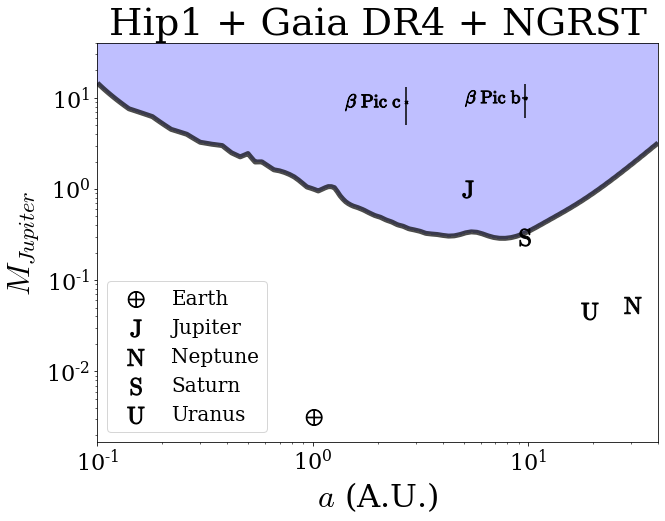

In [14]:
"""
Now we will use the calculated chisquareds to make a 2d contour plot of the data.
"""

###################
title_font_size = 28
tick_font_size = 32
######
# setting plot parameters
font = {'family' : 'serif',
        'size'   : tick_font_size}
plt.rc('font', **font)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('mathtext', fontset="cm") # fixing latex fonts
#######

def resample(x, y, num):
    f = interp1d(x, y, kind='linear')
    x_lin = np.linspace(np.min(x), np.max(x), num)
    return x_lin, f(x_lin)

separation_samples = 1000
mass_samples = 1000


fig, ax = plt.subplots(figsize=(10, 8))


# use the chisquareds and separations 
separations, chisqds = resample(separations, chisqds, separation_samples) # resample onto log grid
masses = np.linspace(1/600, 40, mass_samples) * u.M_jup

# generate chisquared array for all the masses
chisqds = np.ones((len(masses), len(separations)), dtype=float) * np.array(chisqds)
# apply the scaling with the astrometric signal (saves having to calculate the fit over the masses).
# This is why we do not calculate chisquared changes in the mass in the previous Cell of this notebook).
chisqds *= (((-masses / mass_star).decompose().value).reshape(-1, 1)) ** 2
masses = masses.value
# plotting contours
sigma_contour = np.sqrt(30)
X, Y = np.meshgrid(separations.flatten(), masses.flatten())
cs1 = ax.contour(X, Y, np.sqrt(chisqds), [sigma_contour], colors='black',
linestyles=['solid'], linewidths=5, alpha=0.7)
cs2 = ax.contourf(X, Y, np.sqrt(chisqds), [0, sigma_contour, 10000], extend='both',
                  colors=['w', 'b'], alpha=0.25)
cs2.cmap.set_under('w')
cs2.cmap.set_over('b')
ax.set_title(plot_title)
#ax.clabel(contours, inline=True, fontsize=20, fmt='%1.1f', manual=[(3, 1)], inline_spacing=0)

# plotting planets
solar_system = [{'mass': 1 / 317.8, 'a': 1, 'name': 'Earth', 'marker': r'$\oplus$'},
                {'mass': 1, 'a': 5.2, 'name': 'Jupiter', 'marker': r'${\rm J}$'},
                {'mass': 17.15 / 317.8, 'a': 30.11, 'name': 'Neptune', 'marker': r'${\rm N}$'},
                {'mass': 95.16 / 317.8, 'a': 9.55, 'name': 'Saturn', 'marker': r'${\rm S}$'},
                {'mass': 14.54 / 317.8, 'a': 19.2, 'name': 'Uranus', 'marker': r'${\rm U}$'}]
betapic = [{'mass': 10, 'a': 9.65, 'name': r'$\beta~{\rm Pic~b}$', 'marker': r'$\beta~{\rm Pic~b}$',
            'merr': 4, 'aerr': .3},
           {'mass': 9, 'a': 2.7, 'name': r'$\beta~{\rm Pic~c}$', 'marker': r'$\beta~{\rm Pic~c}$',
            'merr': 4, 'aerr': 0.02},
           ]

for planet in solar_system:
    ax.scatter(planet['a'], planet['mass'], marker=planet['marker'], color='k', label=planet['name'],
               s=300, zorder=9)

ax.legend(loc='lower left', prop={'size': 20})

for planet in betapic:
    ax.scatter(planet['a']*0.7, planet['mass'], marker=planet['marker'],
               color='k', label=planet['name'],
               s=3000, zorder=9)
    ax.scatter(planet['a'], planet['mass'], marker='x', color='k', s=10, zorder=9)
    ax.errorbar(planet['a'], planet['mass'],
                yerr=planet['merr'], xerr=planet['aerr'], zorder=9, color='k')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$M_{Jupiter}$')
ax.set_xlabel(r'$a$ (A.U.)')

plt.tight_layout()
plt.show()
